# Low-VA Final- Optimal Hyperparameters
Hyperparameter tuning done in lowva-hyperparameterTuning

In [1]:
#change your dependencies as you see fit
import tensorflow as tf
import keras_tuner as kt
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import glob 
import matplotlib.pyplot as plt
import h5py 
import random 
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from collections import OrderedDict
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve
%load_ext tensorboard

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tf.keras.backend.set_image_data_format('channels_last')

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Model Evaluation (Loss, Accuracy, ROC)

In [4]:
# Plots the train and validation loss during training
def plt_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    p = plt.plot(epochs, train_loss, 'y', label='Training loss');
    p = plt.plot(epochs, val_loss, 'r', label='Validation loss');
    p = plt.title('Training and validation loss');
    p = plt.xlabel('Epochs');
    p = plt.ylabel('Loss');
    p = plt.legend()
    plt.show()

# Plots the train and validation loss during training
def plt_acc(history):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(train_acc) + 1)
    p = plt.plot(epochs, train_acc, 'y', label='Training acc');
    p = plt.plot(epochs, val_acc, 'r', label='Validation acc');
    p = plt.title('Training and validation accuracy');
    p = plt.xlabel('Epochs');
    p = plt.ylabel('Accuracy');
    p = plt.legend()
    plt.show()

# Plots ROC curve for validation
# validation_dataset = tensor object that you input
# y_score = output from the model.predict
def plt_roc(validation_dataset, y_pred, type = 'validation'): 
    y_true_array = []
    for x,y in validation_dataset:
        for y_val in y:
            y_true_array.append(y_val.numpy()[0]) 
    y_pred_array = np.array(y_pred)

    fpr , tpr , thresholds = roc_curve(y_true_array, y_pred_array)
    plt.plot(fpr,tpr);
    plt.axis([0,1,0,1]); 
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    if (type == 'validation'):
        plt.title('Validation ROC')
    if (type == 'test'):
        plt.title('Test ROC')
    plt.show()
    
def val_thresholds(validation_dataset):
    thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
    maxf1threshold = 0.0
    maxf1 = 0.0
    maxResults = []
    for threshold in thresholds:
        print('\nThreshold:', threshold)
        metrics = [tf.keras.metrics.TruePositives(name='tp', thresholds=threshold), 
                    tf.keras.metrics.FalsePositives(name='fp', thresholds=threshold), 
                    tf.keras.metrics.TrueNegatives(name='tn', thresholds=threshold), 
                    tf.keras.metrics.FalseNegatives(name='fn', thresholds=threshold), 
                    tf.keras.metrics.Recall(name='sen', thresholds=threshold), 
                    tf.keras.metrics.Precision(name='prc', thresholds=threshold), 
                    tf.keras.metrics.AUC(name='auroc', curve='ROC'), 
                    tf.keras.metrics.AUC(name='auprc', curve='PR'), ]
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

        loss, tp, fp, tn, fn, sens, prec, auroc, auprc = model.evaluate(validation_dataset)
        if sens * prec == 0.0:
            f1 = 0.0
        else:
            f1 = 2/(1/sens + 1/prec)

        if f1 > maxf1:
            maxf1threshold = threshold
            maxf1 = f1
            maxResults = [tp, fp, tn, fn, sens, prec]

    print('\nBest threshold on Test Set:', maxf1threshold)
    print('Best F1:', maxf1*100)
    print('True Positives:', maxResults[0])
    print('False Positives:', maxResults[1])
    print('True Negatives:', maxResults[2])
    print('False Negatives:', maxResults[3])
    print('Sensitivity/Recall:', maxResults[4]*100)
    print('Precision:', maxResults[5]*100)
    return maxf1threshold

def holdout_final_eval(test_dataset, maxf1threshold):
    metrics = [tf.keras.metrics.TruePositives(name='tp', thresholds=maxf1threshold), 
            tf.keras.metrics.FalsePositives(name='fp', thresholds=maxf1threshold), 
            tf.keras.metrics.TrueNegatives(name='tn', thresholds=maxf1threshold), 
            tf.keras.metrics.FalseNegatives(name='fn', thresholds=maxf1threshold), 
            tf.keras.metrics.Recall(name='sens', thresholds=maxf1threshold), 
            tf.keras.metrics.Precision(name='prec', thresholds=maxf1threshold), 
            tf.keras.metrics.AUC(name='auroc', curve='ROC'), 
            tf.keras.metrics.AUC(name='auprc', curve='PR'), ]
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    loss, tp, fp, tn, fn, sens, prec, auroc, auprc = model.evaluate(test_dataset)
    print('AUROC:', auroc*100)
    print('Sensitivity/Recall:', sens*100)
    print('Precision:', prec*100)
    if sens * prec == 0.0:
        f1 = 0.0
        print('F1 not applicable')
    else:
        f1 = 2/(1/sens + 1/prec)
        print('F1:', f1*100)
    print('True Positives', tp)
    print('False Positives', fp)
    print('True Negatives', tn)
    print('False Negatives', fn)

# Loading Data

In [5]:
clamp_output_df = pd.read_csv('gs://stanfordoptimagroup/STRIDE/lowva/clamp_output_postprocessing.csv', delimiter = ",")

In [6]:
# code to load the pre-trained embeddings and dataset
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

csv.field_size_limit(1310720);

print('\nloading structured data')
with open('../lowva-structured-02.csv', 'r') as f:
    r = csv.reader(f)
    i = 0
    structuredDict = {}
    outputDict = {}
    for row in r:
        i += 1
        if i == 1:
            continue
        else:
            key = row[0].strip()
            values = np.array([float(i) for i in row[2:] if isfloat(i)])
            structuredDict[key] = values
            outputDict[key]= np.array([int(row[1])])

131072


loading structured data


In [7]:
print('\nCreating tokenDict')
tokenDict=OrderedDict() #to ensure that the dictionary will maintain an order

def check_negation(row):
    if(row['Assertion'] == 'present'):
        return row['CUI_clean'] + 'p'
    else:
        return row['CUI_clean'] + 'n'

for index, row in clamp_output_df.iterrows():
    if (str(row['PID']) in structuredDict): #make sure only including ones that have output results
        if (isinstance(row['CUI_clean'], str)): #to be changed later
            key = str(row['PID'])
            if (key in tokenDict):
                oldValue = tokenDict[key]
                oldValue.append(check_negation(row))
                tokenDict[key] = oldValue
            else: 
                tokenDict[key] = [check_negation(row)]
token_df = pd.DataFrame(list(tokenDict.items()),columns = ['PID','CUI']) 

# One hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)

tokensOneHot = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(token_df.pop('CUI')),
                index=token_df.index,
                columns=mlb.classes_)

#Variance Filtering: filtering out near zero variance features from data frame while preserving names
selector = VarianceThreshold(.99 * (1 - .99))
tokensArray = selector.fit_transform(tokensOneHot)


Creating tokenDict


In [28]:
print('loading and joining with unstructured data')
# lowva_structured = pd.read_csv('gs://stanfordoptimagroup/STRIDE/lowva/lowva-structured-02.csv', delimiter = ",")

outputArray = []
structuredArray = []
for key in tokenDict: #to make sure that it's the same order as the tokenArray
    structvalues = structuredDict[key]
    output = outputDict[key]
    
    structuredArray.append(structvalues)
    outputArray.append(output)

del structuredDict
del outputDict
del tokenDict

outputArray = np.array(outputArray)
structuredArray = np.array(structuredArray)
tokenArray = tokensArray.toarray() # after variance filtering, need to convert from sparse array to dense

print(tokenArray.shape, structuredArray.shape, outputArray.shape)

loading and joining with unstructured data
(4393, 1078) (4393, 556) (4393, 1)


# (Model A) Structured Model

In [9]:
total_input = tf.data.Dataset.from_tensor_slices(structuredArray)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

2021-09-12 05:39:00.172291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
sl = tf.keras.layers.Dense(480, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
sl = tf.keras.layers.Dropout(0.5)(sl)
sl = tf.keras.layers.Dense(608, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)

model = tf.keras.Model(inputs = input2, outputs = output)
model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)
# model.save_weights('final/struct00_lowva_weights')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 556)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                35648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 39,873
Trainable params: 39,873
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
253/253 [==============================] - 2s 4ms/step - loss: 1.5663 - tp: 201.2441 - fp: 129.1063 - tn: 1080

[0.573265790939331,
 56.0,
 23.0,
 176.0,
 45.0,
 0.5544554591178894,
 0.7088607549667358,
 0.7818797826766968,
 0.7733333110809326]

loss: 0.5712 - tp: 59.0000 - fp: 25.0000 - tn: 174.0000 - fn: 42.0000 - sen: 0.5842 - prc: 0.7024 - auroc: 0.7858 - acc: 0.7767

In [11]:
model.save_weights('final/struct00_lowva_weights')

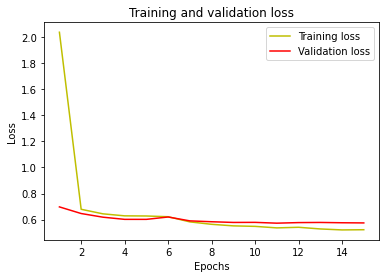

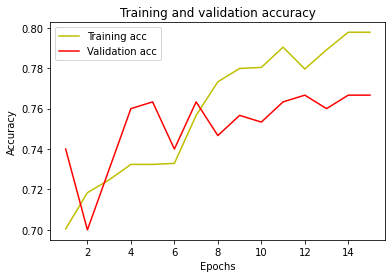

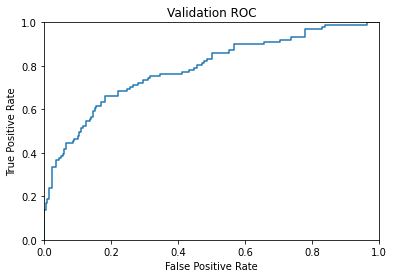

In [12]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

# (Model C) CUI One-hot text model

In [27]:
total_input = tf.data.Dataset.from_tensor_slices(tokenArray)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [28]:
input2 = tf.keras.Input(shape=(tokenArray.shape[1],))
sl = tf.keras.layers.Dense(608, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
sl = tf.keras.layers.Dropout(0.40)(sl)
sl = tf.keras.layers.Dense(608, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)

model = tf.keras.Model(inputs = input2, outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset) #prints out the metrics
model.save_weights('final/struct01_lowva_weights')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1078)]            0         
_________________________________________________________________
dense_10 (Dense)             (None, 608)               656032    
_________________________________________________________________
dropout_4 (Dropout)          (None, 608)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 608)               370272    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 609       
Total params: 1,026,913
Trainable params: 1,026,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
253/253 [==============================] - 3s 6ms/step - loss: 11.8787 - tp: 28.2520 - fp: 60.8307 - tn:

[0.7006216645240784,
 55.0,
 50.0,
 149.0,
 46.0,
 0.5445544719696045,
 0.523809552192688,
 0.7028459310531616,
 0.6800000071525574]

loss: 0.7006 - tp: 55.0000 - fp: 50.0000 - tn: 149.0000 - fn: 46.0000 - sen: 0.5446 - prc: 0.5238 - auroc: 0.7028 - acc: 0.6800

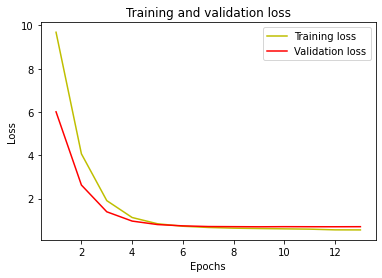

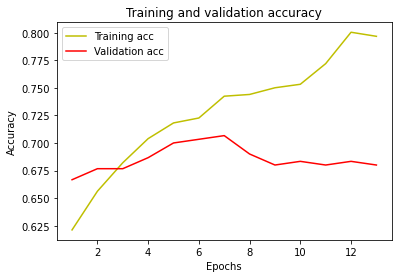

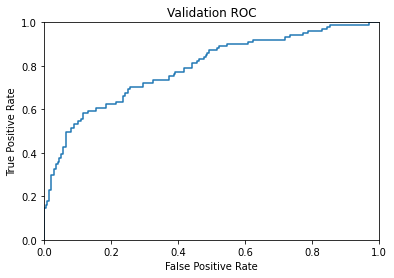

In [29]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

# (Model F) Structured and CUI one-hot combined model

In [16]:
total_input = tf.data.Dataset.from_tensor_slices(np.hstack((tokenArray, structuredArray)))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [17]:
input2 = tf.keras.Input(shape=((tokenArray.shape[1]+structuredArray.shape[1]),))
sl = tf.keras.layers.Dense(704, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
sl = tf.keras.layers.Dropout(0.50)(sl)
sl = tf.keras.layers.Dense(448, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)

#model = tf.keras.Model(inputs = input1, outputs = output)
model = tf.keras.Model(inputs = input2, outputs = output)
#model = tf.keras.Model(inputs = (input1, input2), outputs = output)
model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)
# model.save_weights('final/struct02_lowva_weights')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1634)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 704)               1151040   
_________________________________________________________________
dropout_2 (Dropout)          (None, 704)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 448)               315840    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 449       
Total params: 1,467,329
Trainable params: 1,467,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
253/253 [==============================] - 3s 6ms/step - loss: 5.1125 - tp: 281.9409 - fp: 171.7087 - tn

[0.6008745431900024,
 61.0,
 26.0,
 173.0,
 40.0,
 0.603960394859314,
 0.7011494040489197,
 0.7859594821929932,
 0.7799999713897705]

loss: 0.6009 - tp: 61.0000 - fp: 26.0000 - tn: 173.0000 - fn: 40.0000 - sen: 0.6040 - prc: 0.7011 - auroc: 0.7860 - acc: 0.7800

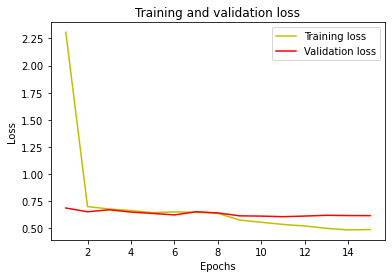

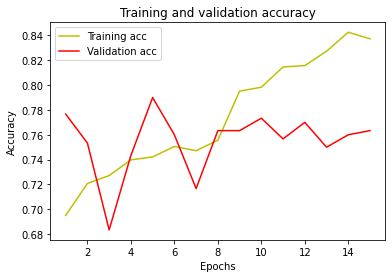

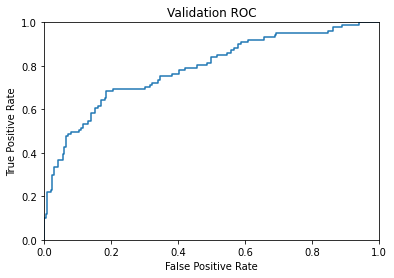

In [40]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

# Loading Data- Cui2vec embedding

In [12]:
# Variance Threshold for word embedding (cui2vec)
selector = VarianceThreshold(.99 * (1 - .99));
selector.fit(tokensOneHot);
tokenArray_df = tokensOneHot[tokensOneHot.columns[selector.get_support(indices=True)]];

In [13]:
vocabulary = set()
cuiDict={}

# Returning only positive cui's
def adapt_cui(cui):
    if 'n' in cui:
        return ' '
    if 'p' in cui:
        return cui[0:len(cui)-1]

# creating a vocab out of the cui's (creating a sentence from the extracted name-entities)
pid_list_tokenDict = [*tokenDict]

for index, row in tokenArray_df.iterrows(): #tokenArray_df is after variance filtering
    for column in tokenArray_df: #iterating through all the columns to get the cui's
        if (row[column] == 1): #only if patient has the cui
            value = adapt_cui(column)
            vocabulary.add(value)
            key = pid_list_tokenDict[index]
            if (key in cuiDict):
                oldValue = cuiDict[key]
                newValue = oldValue + ' ' + value
                cuiDict[key] = newValue
            else: 
                cuiDict[key] = value

print(len(cuiDict))

4392


### Loading CUI's to create cui2vec embeddings (converting to "sentence of cui's")

In [14]:
# Loading pertrained cui2vec embedding

print('loading cui2vec vectors')
cui2vec_df = pd.read_csv('gs://stanfordoptimagroup/STRIDE/lowva/cui2vec_pretrained.csv', delimiter = ",")
cui2vec_df.rename(columns={'Unnamed: 0':'CUI'}, inplace=True)
cui2vec_map = cui2vec_df.set_index('CUI').T.to_dict('list') # Create dictionary from df

print('Loaded %s word vectors.' % len(cui2vec_map))

loading cui2vec vectors
Loaded 109053 word vectors.


### Loading pubmed word embeddings

In [15]:
extrinsicdata_df = pd.read_csv('../lowva-extrinsicdata.csv', delimiter = ",", header=None)

In [16]:
vocabulary_pubmed = []
with open('../pubmed_cbow_vocabulary.txt', 'r') as f:
    for row in f:
        vocabulary_pubmed.append(row.strip())

# Create Tokenizer
vocabulary_pubmed_size = len(vocabulary_pubmed) + 2
print('Vocab Pubmed Size', vocabulary_pubmed_size)
tokenizer_pubmed = tfds.deprecated.text.Tokenizer()

width = 1000
pubmed_embedding_dimension = 300
pubmed_encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_pubmed, tokenizer = tokenizer_pubmed)

print('Creating wordDict')
wordDict = {}

for index, row in extrinsicdata_df.iterrows():
    if (str(row[0]) in cuiDict): #make sure only including ones that have output results
        key = str(row[0])
        words = pubmed_encoder.encode(row[2])
        words = words[0:width]
        if len(words) < width:
            words = words + [0 for i in range(width-len(words))] 
        wordDict[key] = words

print('Max Length of words in patient:', width)

print('loading Pubmed EMR vectors')
model = tf.keras.models.load_model('../pubmed_cbow_embeddings.h5')
pubmed_embedding_matrix = np.zeros((vocabulary_pubmed_size, pubmed_embedding_dimension))
pubmed_e = model.layers[1]
pubmed_embedding_matrix = pubmed_e.get_weights()[0]
print(pubmed_embedding_matrix.shape)
del model

Vocab Pubmed Size 55940
Creating wordDict
Max Length of words in patient: 1000
loading Pubmed EMR vectors


2021-11-08 04:23:17.328093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(55940, 300)


### Creating inputs (structuredArray, outputArray, wordArray, padded_cui)

In [17]:
outputArray = []
structuredArray = []
cuiArray = []
wordArray = []

for key in wordDict: #to make sure that everything is same order
    structvalues = structuredDict[key]
    output = outputDict[key]
    cui = cuiDict[key]
    word = wordDict[key] #TOGGLE
    
    structuredArray.append(structvalues)
    outputArray.append(output)
    cuiArray.append(cui)
    wordArray.append(word) #TOGGLE

outputArray = np.array(outputArray)
structuredArray = np.array(structuredArray)
wordArray = np.array(wordArray)

print(structuredArray.shape, outputArray.shape, len(cuiArray), wordArray.shape)

(4392, 556) (4392, 1) 4392 (4392, 1000)


In [18]:
# Create Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(cuiArray)
vocabulary_size = len(vocabulary) + 1
print('Vocab Size', vocabulary_size)

# Integer encode the documents
encoded_cui = tokenizer.texts_to_sequences(cuiArray)
# print(encoded_cui)

# Pad documents to max length
max_length = max(map(len, encoded_cui)) #getting max length of the number of cui's per patient

# max_length = 4000 #arbitrary number set to decrease the size (only 3 patients have more than 4000 cui's)
padded_cui = tf.keras.preprocessing.sequence.pad_sequences(encoded_cui, maxlen = max_length, padding='post')
print(padded_cui.shape)
print('Max Length of CUI in patient:', max_length)

Vocab Size 816
(4392, 239)
Max Length of CUI in patient: 239


In [19]:
# Create cui2vec embedding

embedding_dimension = 500 #number pulled from the cui2vec pretrained word embeddings
embedding_matrix = np.zeros((vocabulary_size, embedding_dimension))

print('Loaded %s word vectors.' % len(cui2vec_map))

# Creating a weight matrix for words in the training docs
for word, i in tokenizer.word_index.items():
    embedding_vector = cui2vec_map.get(word.upper()) #need to convert to upper case b/c tokenizer makes all lowercase
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Loaded 109053 word vectors.
(816, 500)


# (Model D) Cui2vec text model

In [18]:
total_input = tf.data.Dataset.from_tensor_slices(padded_cui)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [19]:
input1 = tf.keras.Input(shape=(max_length,))
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
nl = tf.keras.layers.Flatten()(nl)
nl = tf.keras.layers.Dense(224, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
nl = tf.keras.layers.Dropout(0.3)(nl)
nl = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

#model = tf.keras.Model(inputs = input1, outputs = output)
#model = tf.keras.Model(inputs = input2, outputs = output)
model = tf.keras.Model(inputs = input1, outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)
model.save_weights('final/struct031b_lowva_weights-XXXX')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 239)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 239, 500)          408000    
_________________________________________________________________
flatten (Flatten)            (None, 119500)            0         
_________________________________________________________________
dense (Dense)                (None, 224)               26768224  
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               28800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129   

2021-08-15 19:12:19.880619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-15 19:12:19.896935: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


253/253 [==============================] - 21s 78ms/step - loss: 3.5577 - tp: 27.0866 - fp: 30.7283 - tn: 1168.0197 - fn: 686.5827 - sen: 0.0351 - prc: 0.4102 - auroc: 0.6043 - acc: 0.6258 - val_loss: 1.8214 - val_tp: 4.0000 - val_fp: 3.0000 - val_tn: 185.0000 - val_fn: 108.0000 - val_sen: 0.0357 - val_prc: 0.5714 - val_auroc: 0.6057 - val_acc: 0.6300
Epoch 2/80
253/253 [==============================] - 19s 74ms/step - loss: 1.6379 - tp: 153.2087 - fp: 77.1260 - tn: 1122.5118 - fn: 559.5709 - sen: 0.2006 - prc: 0.6776 - auroc: 0.7182 - acc: 0.6650 - val_loss: 1.3762 - val_tp: 30.0000 - val_fp: 33.0000 - val_tn: 155.0000 - val_fn: 82.0000 - val_sen: 0.2679 - val_prc: 0.4762 - val_auroc: 0.6082 - val_acc: 0.6167
Epoch 3/80
253/253 [==============================] - 19s 75ms/step - loss: 1.2151 - tp: 255.4528 - fp: 126.8228 - tn: 1077.4055 - fn: 452.7362 - sen: 0.3465 - prc: 0.6688 - auroc: 0.7599 - acc: 0.6970 - val_loss: 1.1538 - val_tp: 18.0000 - val_fp: 21.0000 - val_tn: 167.0000 - v

[0.9293699264526367,
 37.0,
 36.0,
 152.0,
 75.0,
 0.3303571343421936,
 0.5068492889404297,
 0.6223641633987427,
 0.6299999952316284]

loss: 0.9294 - tp: 37.0000 - fp: 36.0000 - tn: 152.0000 - fn: 75.0000 - sen: 0.3304 - prc: 0.5068 - auroc: 0.6224 - acc: 0.6300

20/20 [==============================] - 1s 40ms/step - loss: 0.9294 - tp: 37.0000 - fp: 36.0000 - tn: 152.0000 - fn: 75.0000 - sen: 0.3304 - prc: 0.5068 - auroc: 0.6224 - acc: 0.6300


[0.9293699264526367,
 37.0,
 36.0,
 152.0,
 75.0,
 0.3303571343421936,
 0.5068492889404297,
 0.6223641633987427,
 0.6299999952316284]

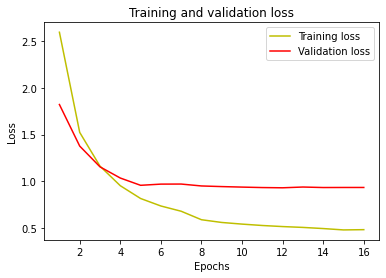

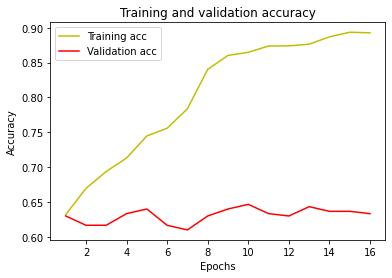

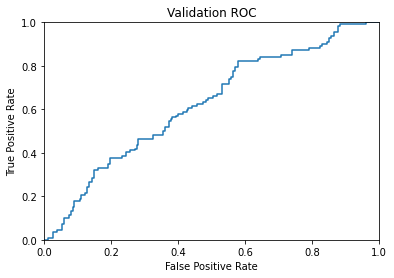

In [20]:
model.evaluate(validation_dataset)
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

# (Model G) Structured and CUI cui2vec combined model

In [56]:
total_input = tf.data.Dataset.from_tensor_slices((padded_cui, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [57]:
input1 = tf.keras.Input(shape=(max_length,))
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
nl = tf.keras.layers.Flatten()(nl)
nl = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
nl = tf.keras.layers.Dropout(0.6)(nl)
nl = tf.keras.layers.Dense(320, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
sl = tf.keras.layers.Dense(416, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
sl = tf.keras.layers.Dropout(0.50)(sl)
sl = tf.keras.layers.Dense(480, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

combo = tf.keras.layers.Concatenate()([nl, sl])
combo = tf.keras.layers.Dense(448, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)
nl = combo

output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

#model = tf.keras.Model(inputs = input1, outputs = output)
#model = tf.keras.Model(inputs = input2, outputs = output)
model = tf.keras.Model(inputs = (input1, input2), outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)
model.save_weights('final/struct035b_lowva_weights-XXXX')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 239)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 239, 500)     408000      input_14[0][0]                   
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 119500)       0           embedding_10[0][0]               
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 556)]        0                                            
____________________________________________________________________________________________

[0.552009105682373,
 70.0,
 26.0,
 162.0,
 42.0,
 0.625,
 0.7291666865348816,
 0.8251804709434509,
 0.7733333110809326]

loss: 0.5541 - tp: 61.0000 - fp: 24.0000 - tn: 164.0000 - fn: 51.0000 - sen: 0.5446 - prc: 0.7176 - auroc: 0.8262 - acc: 0.7500

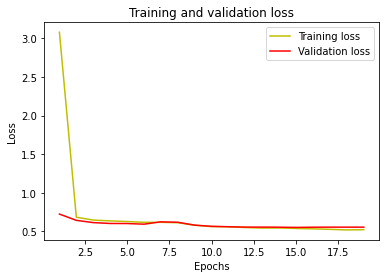

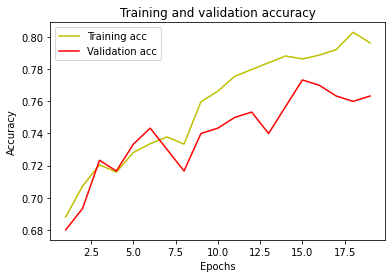

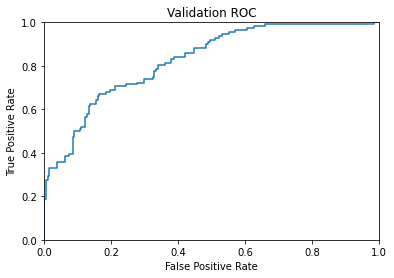

In [58]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

## (Model H) Structured and cui2vec text model and fully connected word embedding model

In [18]:
total_input = tf.data.Dataset.from_tensor_slices((padded_cui, wordArray, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

max_length = max(map(len, encoded_cui))

In [19]:
input1 = tf.keras.Input(shape=(max_length,))
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
nl = tf.keras.layers.Flatten()(nl)
nl = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
nl = tf.keras.layers.Dropout(0)(nl)
nl = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

input2 = tf.keras.Input(shape=(width,))
nl2 = tf.keras.layers.Embedding(vocabulary_pubmed_size, pubmed_embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(pubmed_embedding_matrix), input_length = width, trainable=False)(input2)
nl2 = tf.keras.layers.Flatten()(nl2)
nl2 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl2)
nl2 = tf.keras.layers.Dropout(0.8)(nl2)
nl2 = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl2)

input3 = tf.keras.Input(shape=(structuredArray.shape[1],))
sl = tf.keras.layers.Dense(160, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input3)
sl = tf.keras.layers.Dropout(0.6)(sl)
sl = tf.keras.layers.Dense(896, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

combo = tf.keras.layers.Concatenate()([nl, nl2, sl])
combo = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)
nl = combo

output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

#model = tf.keras.Model(inputs = input1, outputs = output)
#model = tf.keras.Model(inputs = input2, outputs = output)
model = tf.keras.Model(inputs = (input1, input2, input3), outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 239)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 239, 500)     408000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 300)    16782000    input_2[0][0]                    
______________________________________________________________________________________________

2021-08-23 15:49:11.928947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-23 15:49:12.014169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


253/253 [==============================] - 46s 166ms/step - loss: 9.3278 - tp: 233.1535 - fp: 235.7126 - tn: 966.5787 - fn: 476.9724 - sen: 0.3325 - prc: 0.4696 - auroc: 0.5941 - acc: 0.6128 - val_loss: 2.1431 - val_tp: 49.0000 - val_fp: 28.0000 - val_tn: 160.0000 - val_fn: 63.0000 - val_sen: 0.4375 - val_prc: 0.6364 - val_auroc: 0.7441 - val_acc: 0.6967
Epoch 2/80
253/253 [==============================] - 41s 163ms/step - loss: 2.1227 - tp: 259.7795 - fp: 176.0079 - tn: 1026.6457 - fn: 449.9843 - sen: 0.3780 - prc: 0.5928 - auroc: 0.7015 - acc: 0.6764 - val_loss: 1.1378 - val_tp: 41.0000 - val_fp: 18.0000 - val_tn: 170.0000 - val_fn: 71.0000 - val_sen: 0.3661 - val_prc: 0.6949 - val_auroc: 0.7669 - val_acc: 0.7033
Epoch 3/80
253/253 [==============================] - 41s 162ms/step - loss: 1.1674 - tp: 291.0512 - fp: 165.8898 - tn: 1033.9331 - fn: 421.5433 - sen: 0.4143 - prc: 0.6318 - auroc: 0.7334 - acc: 0.6920 - val_loss: 1.1358 - val_tp: 39.0000 - val_fp: 18.0000 - val_tn: 170.00

[0.5555747747421265,
 61.0,
 23.0,
 165.0,
 51.0,
 0.5446428656578064,
 0.726190447807312,
 0.8252041935920715,
 0.753333330154419]

In [53]:
model.save_weights('final/struct036b_lowva_weights-XXXX')

loss: 2.0188 - tp: 42.0000 - fp: 45.0000 - tn: 143.0000 - fn: 70.0000 - sen: 0.3750 - prc: 0.4828 - auroc: 0.6193 - acc: 0.6167

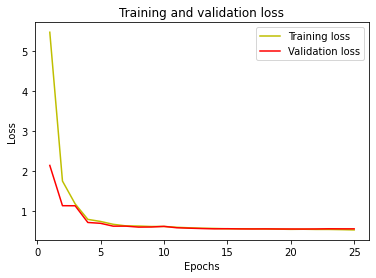

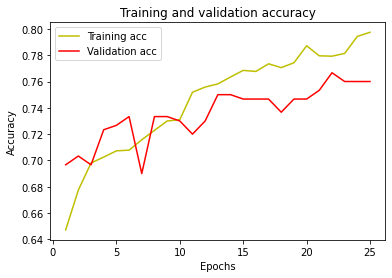

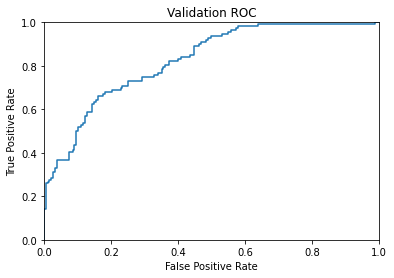

In [20]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

20/20 [==============================] - 1s 44ms/step - loss: 0.5914 - tp: 64.0000 - fp: 23.0000 - tn: 164.0000 - fn: 49.0000 - sen: 0.5664 - prc: 0.7356 - auroc: 0.7889 - acc: 0.7600


[0.5914145708084106,
 64.0,
 23.0,
 164.0,
 49.0,
 0.5663716793060303,
 0.7356321811676025,
 0.7888646721839905,
 0.7599999904632568]

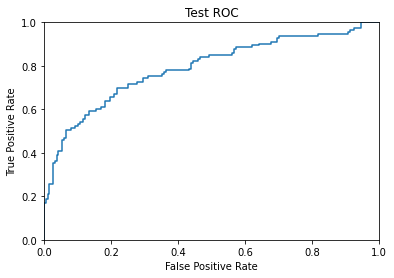

In [21]:
model.evaluate(test_dataset)
y_pred_test = model.predict(test_dataset)
plt_roc(test_dataset, y_pred_test, 'test')

# Loading Data- TextCNN

In [20]:
# code to load the pre-trained embeddings and dataset
import tensorflow_datasets as tfds
import numpy as np
import csv

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

with open('../pubmed_cbow_vocabulary.txt', 'r') as f:
    vocabulary = []
    for row in f:
        vocabulary.append(row.strip())

vocabulary_size = len(vocabulary) + 2
tokenizer = tfds.deprecated.text.Tokenizer()

width = 1000
embedding_dimension = 300
encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary, tokenizer=tokenizer)
csv.field_size_limit(1310720)
print('\nloading structured data')
with open('../lowva-structured-02.csv', 'r') as f:
    r = csv.reader(f)
    i = 0
    structuredDict = {}
    for row in r:
        i += 1
        if i == 1:
            continue
        else:
            key = row[0].strip()
            values = np.array([float(i) for i in row[2:] if isfloat(i)])
            structuredDict[key] = values

print('loading and joining with unstructured data')
with open('../lowva-extrinsicdata.csv', 'r') as f:
    r = csv.reader(f)
    i = 0
    tokenArray = []
    outputArray = []
    structuredArray = []
    for row in r:
        i += 1
        if row[0].strip() in structuredDict:
            structvalues = structuredDict[row[0].strip()]
            output = np.array([int(row[1])])
            tokens = encoder.encode(row[2])
            tokens = tokens[0:width]
            if len(tokens) < width:
                tokens = tokens + [0 for i in range(width-len(tokens))]

            structuredArray.append(structvalues)
            outputArray.append(output)
            tokenArray.append(tokens)

del structuredDict
tokenArray = np.array(tokenArray)
outputArray = np.array(outputArray)
structuredArray = np.array(structuredArray)

print(tokenArray.shape, structuredArray.shape, outputArray.shape)

print('loading Pubmed EMR vectors')
model = tf.keras.models.load_model('../pubmed_cbow_embeddings.h5')
embedding_matrix = np.zeros((vocabulary_size, embedding_dimension))
e = model.layers[1]
embedding_matrix = e.get_weights()[0]
print(embedding_matrix.shape)
del model

1310720


loading structured data
loading and joining with unstructured data
(5548, 1000) (5548, 556) (5548, 1)
loading Pubmed EMR vectors
(55940, 300)


# (Model B) CNN word embedding text model

In [22]:
total_input = tf.data.Dataset.from_tensor_slices(tokenArray)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [23]:
input1 = tf.keras.Input(shape=(width,))
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = width, trainable=False)(input1)
nl = tf.keras.layers.Dense(512, activation='relu')(nl)
nl = tf.keras.layers.Dropout(0.50)(nl)
kernels = [3, 5, 7, 10]
pooled = []
for kernel_size in kernels:
    mini_layer = tf.keras.layers.Conv1D(256, kernel_size, activation='relu')(nl)
    mini_pooled = tf.keras.layers.MaxPooling1D(width - kernel_size + 1)(mini_layer)
    pooled.append(mini_pooled)
nl = tf.keras.layers.Concatenate(axis=1)(pooled)
nl = tf.keras.layers.Flatten()(nl)
nl = tf.keras.layers.Dropout(0.50)(nl)
nl = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
nl = tf.keras.layers.Dropout(0.5)(nl)
nl = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

model = tf.keras.Model(inputs = input1, outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 300)    16782000    input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1000, 512)    154112      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1000, 512)    0           dense_4[0][0]                    
____________________________________________________________________________________________

2021-11-08 04:30:42.310259: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-08 04:30:42.386123: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


330/330 [==============================] - 370s 1s/step - loss: 7.1367 - tp: 137.7583 - fp: 199.5529 - tn: 1272.7190 - fn: 879.9124 - sen: 0.1858 - prc: 0.4054 - auroc: 0.5027 - acc: 0.5534 - val_loss: 1.2232 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 176.0000 - val_fn: 124.0000 - val_sen: 0.0000e+00 - val_prc: 0.0000e+00 - val_auroc: 0.5616 - val_acc: 0.5867
Epoch 2/80
330/330 [==============================] - 382s 1s/step - loss: 1.0383 - tp: 13.6103 - fp: 25.3293 - tn: 1444.8429 - fn: 1006.1601 - sen: 0.0173 - prc: 0.3453 - auroc: 0.5309 - acc: 0.5845 - val_loss: 0.7729 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 176.0000 - val_fn: 124.0000 - val_sen: 0.0000e+00 - val_prc: 0.0000e+00 - val_auroc: 0.5556 - val_acc: 0.5867
Epoch 3/80
330/330 [==============================] - 384s 1s/step - loss: 0.7531 - tp: 57.4139 - fp: 79.0604 - tn: 1391.4864 - fn: 961.9819 - sen: 0.0480 - prc: 0.3575 - auroc: 0.5764 - acc: 0.5819 - val_loss: 0.7128 - val_tp: 31.0000 - val_fp: 18

[0.5362467765808105,
 72.0,
 25.0,
 151.0,
 52.0,
 0.5806451439857483,
 0.7422680258750916,
 0.8115377426147461,
 0.7433333396911621]

loss: 0.5362 - tp: 72.0000 - fp: 25.0000 - tn: 151.0000 - fn: 52.0000 - sen: 0.5806 - prc: 0.7423 - auroc: 0.8115 - acc: 0.7433

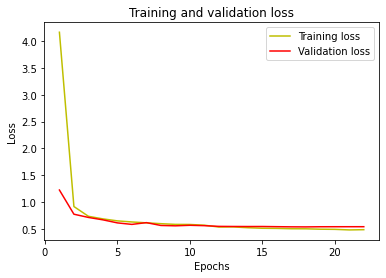

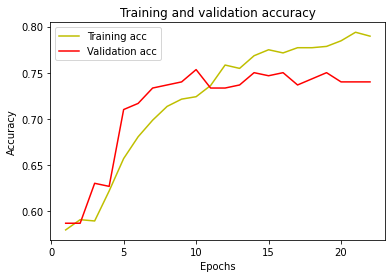

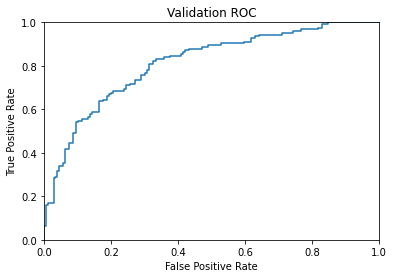

In [24]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)

# (Model E) Structured and CNN word embedding combined model

In [25]:
total_input = tf.data.Dataset.from_tensor_slices((tokenArray, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [ ]:
input1 = tf.keras.Input(shape=(width,)) 
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = width, trainable=False)(input1) 
nl = tf.keras.layers.Dense(512, activation='relu')(nl) 
nl = tf.keras.layers.Dropout(0.50)(nl) 
kernels = [3, 5, 7, 10] 
pooled = [] 
for kernel_size in kernels: 
    mini_layer = tf.keras.layers.Conv1D(256, kernel_size, activation='relu')(nl) 
    mini_pooled = tf.keras.layers.MaxPooling1D(width - kernel_size + 1)(mini_layer) 
    pooled.append(mini_pooled) 
nl = tf.keras.layers.Concatenate(axis=1)(pooled) 
nl = tf.keras.layers.Flatten()(nl) 
nl = tf.keras.layers.Dropout(0.50)(nl) 
nl = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl) 

input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
sl = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)

combo = tf.keras.layers.Concatenate()([nl, sl])
nl = combo
nl = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl) 
nl = tf.keras.layers.Dropout(0.5)(nl) 
nl = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

model = tf.keras.Model(inputs = (input1, input2), outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 300)    16782000    input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1000, 512)    154112      embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 1000, 512)    0           dense_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)